In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.5/924.5 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings

import pandas as pd
import numpy as np
import plotly.express as px 
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
train = pd.read_csv('optiver-realized-volatility-prediction/train.csv')
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [6]:
book_order= pd.read_parquet('optiver-realized-volatility-prediction/book_train.parquet/stock_id=0')
trade_order=  pd.read_parquet('optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0')
stock_id = '0'
book_order = book_order[book_order['time_id']==5]
book_order.loc[:,'stock_id'] = stock_id
trade_order = trade_order[trade_order['time_id']==5]
trade_order.loc[:,'stock_id'] = stock_id

In [7]:
book_order.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [8]:
trade_order.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [9]:
# Create "return" column
book_order["return"] = ((book_order['bid_price1'] * book_order['ask_size1'] +
                                book_order['ask_price1'] * book_order['bid_size1']) / (
                                       book_order['bid_size1']+ book_order['ask_size1'])).pct_change() * 100
print("book_order shape:", book_order.shape)
print(book_order.info())
book_order.head()

book_order shape: (302, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 301
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_id            302 non-null    int16  
 1   seconds_in_bucket  302 non-null    int16  
 2   bid_price1         302 non-null    float32
 3   ask_price1         302 non-null    float32
 4   bid_price2         302 non-null    float32
 5   ask_price2         302 non-null    float32
 6   bid_size1          302 non-null    int32  
 7   ask_size1          302 non-null    int32  
 8   bid_size2          302 non-null    int32  
 9   ask_size2          302 non-null    int32  
 10  stock_id           302 non-null    object 
 11  return             301 non-null    float64
dtypes: float32(4), float64(1), int16(2), int32(4), object(1)
memory usage: 17.7+ KB
None


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,return
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,0.001407
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,-0.000515
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,0.000000


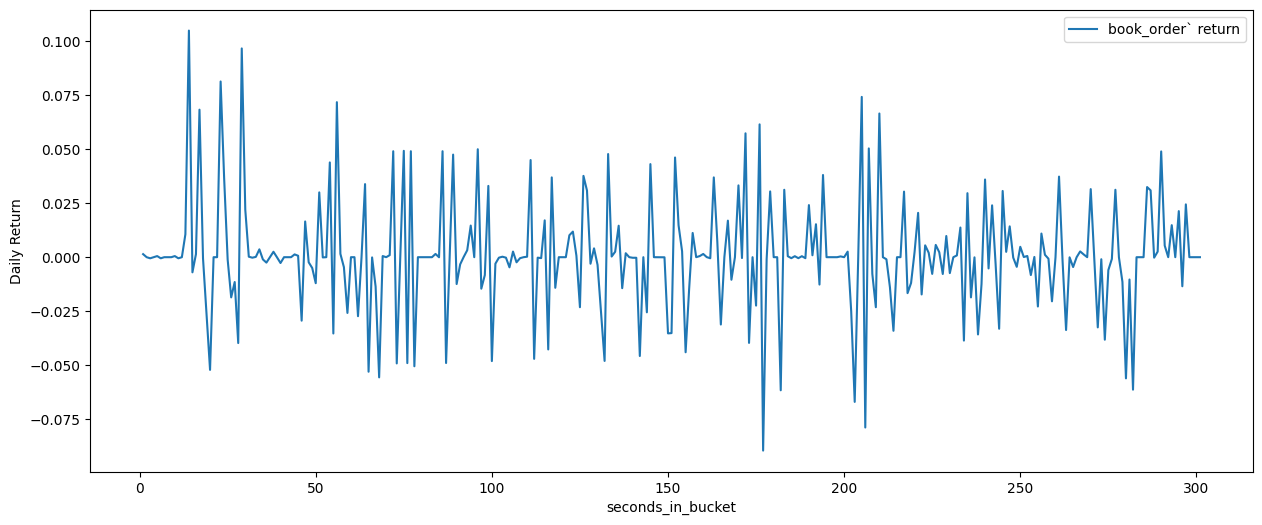

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot `book_order` return
book_order["return"].plot(ax=ax, label="book_order` return")


# Label axes
plt.xlabel("seconds_in_bucket")
plt.ylabel("Daily Return")

# Add legend
plt.legend();

In [11]:
book_order["return"].head()

0         NaN
1    0.001407
2    0.000000
3   -0.000515
4    0.000000
Name: return, dtype: float64

In [12]:
df_bo = book_order["return"].dropna()

In [13]:
df_bo.dropna()

1      0.001407
2      0.000000
3     -0.000515
4      0.000000
5      0.000515
         ...   
297    0.024461
298    0.000000
299    0.000000
300    0.000000
301    0.000000
Name: return, Length: 301, dtype: float64

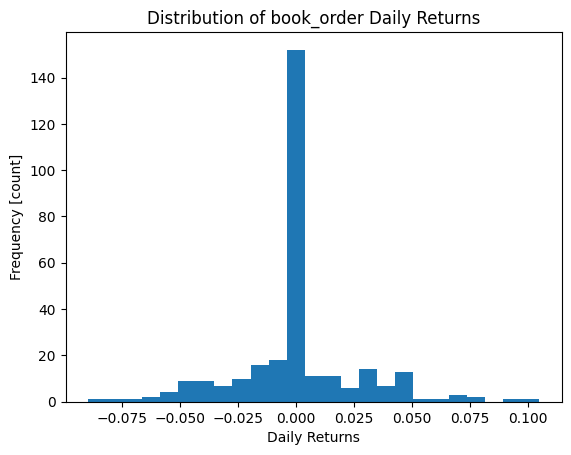

In [14]:
# Create histogram of `book_order`, 25 bins
plt.hist(df_bo, bins=25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of book_order Daily Returns");

In [15]:
book_order_daily_volatility = df_bo.std()
print("book_order_daily_volatility:", book_order_daily_volatility)

book_order_daily_volatility: 0.025967208616268805


In [16]:
book_order_annual_volatility = book_order_daily_volatility * np.sqrt(252)
print("Book_Order Annual Volatility:", book_order_annual_volatility)

Book_Order Annual Volatility: 0.4122166574470856


In [17]:
book_order_rolling_50d_volatility = df_bo.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(book_order_rolling_50d_volatility))
print("rolling_50d_volatility shape:", book_order_rolling_50d_volatility.shape)
book_order_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (252,)


50    0.028339
51    0.028559
52    0.028559
53    0.028557
54    0.029061
Name: return, dtype: float64

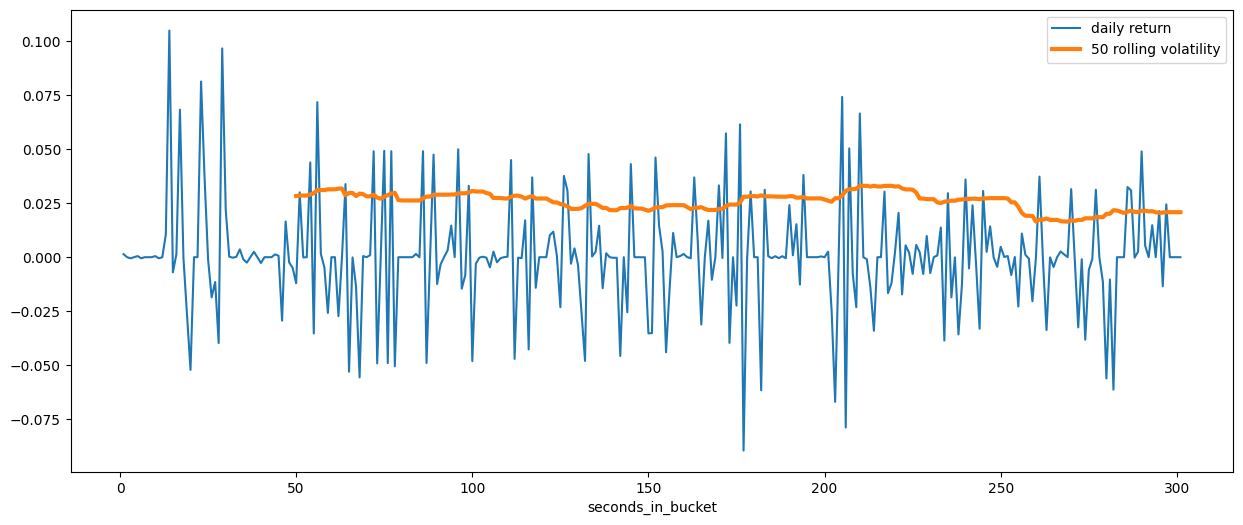

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `book_order return`
df_bo.plot(ax=ax, label="daily return")

# Plot `book_order_rolling_50d_volatility`
book_order_rolling_50d_volatility.plot(ax=ax, label="50 rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("seconds_in_bucket")

# Add legend
plt.legend()

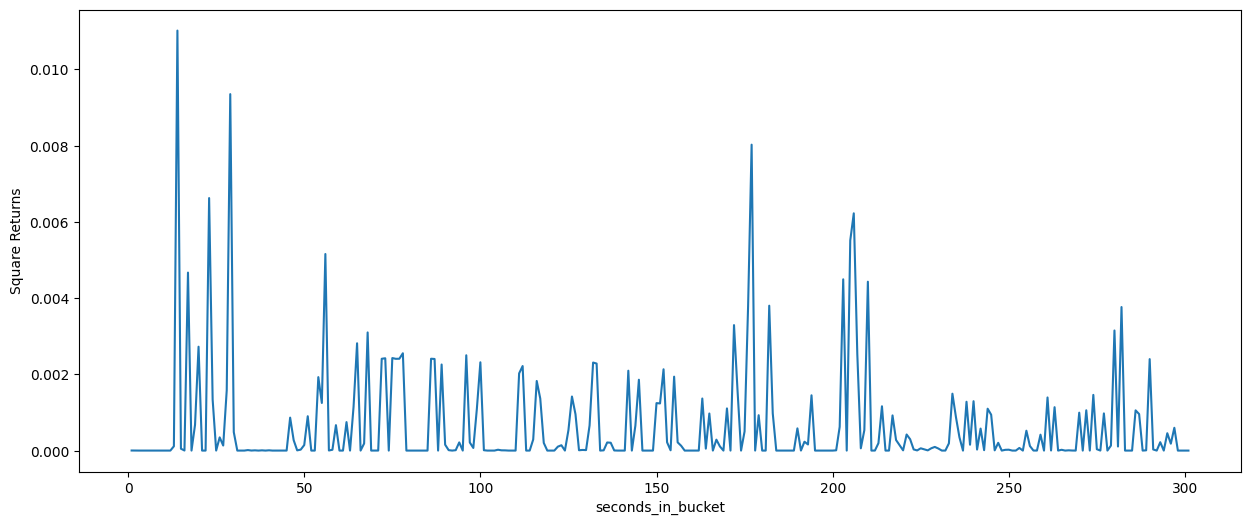

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(df_bo**2).plot(ax=ax)

# Add axis labels
plt.xlabel("seconds_in_bucket")
plt.ylabel("Square Returns");

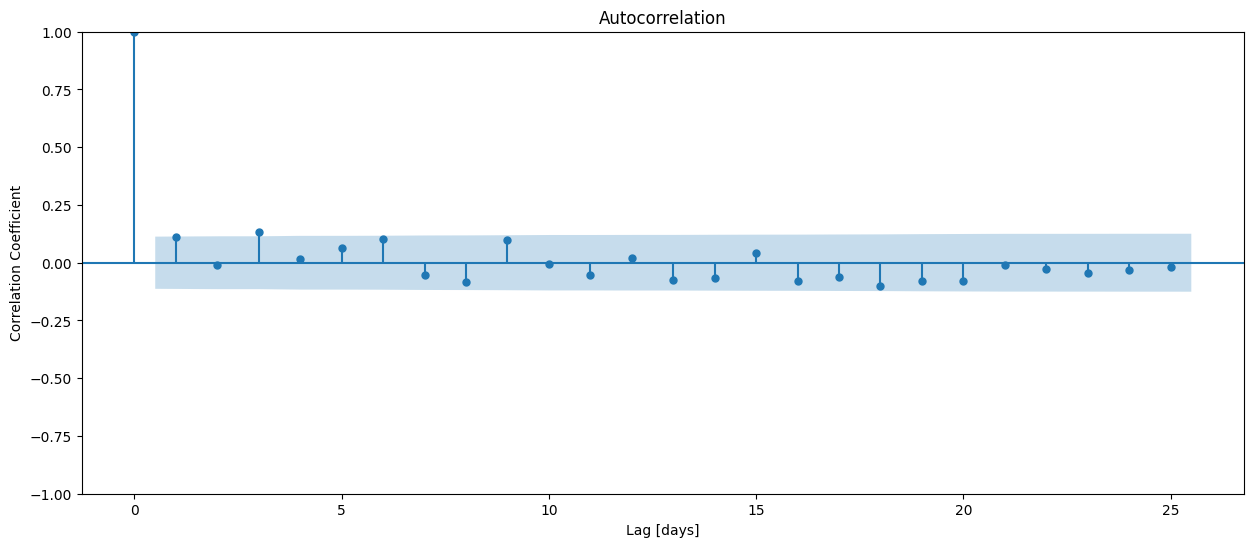

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(df_bo**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

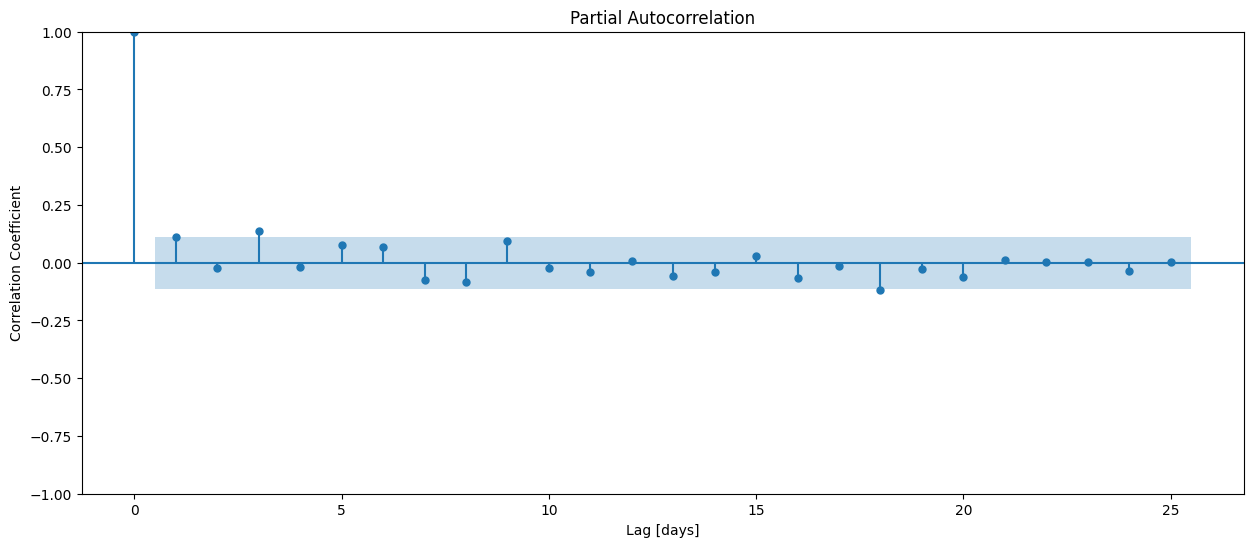

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(df_bo**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [23]:
cutoff_test = int(len(df_bo) * 0.8)
df_bo_train = df_bo.iloc[:cutoff_test]

print("df_bo_train type:", type(df_bo_train))
print("df_bo_train shape:", df_bo_train.shape)
df_bo_train.tail()

df_bo_train type: <class 'pandas.core.series.Series'>
df_bo_train shape: (240,)


236   -0.018623
237   -0.000073
238   -0.035787
239   -0.012407
240    0.035992
Name: return, dtype: float64

In [24]:
# Build and train model
model = arch_model(
    df_bo_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                530.885
Distribution:                  Normal   AIC:                          -1053.77
Method:            Maximum Likelihood   BIC:                          -1039.85
                                        No. Observations:                  240
Date:                Mon, Apr 07 2025   Df Residuals:                      239
Time:                        23:06:47   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.6395e-03  1.438e-03      1.140      0.254 [-1.180e-03,4.459e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6433e-04  1.827e-04      1.447      0.148 [-9.376e-05,6.224e-04]
alpha[1]       0.2649      0.170      1.562      0.118   [-6.748e-02,  0.597]
beta[1]        0.4165      0.275      1.516      0.129      [ -0.122,  0.955]
=============================================================================

Covariance estimator: robust
"""

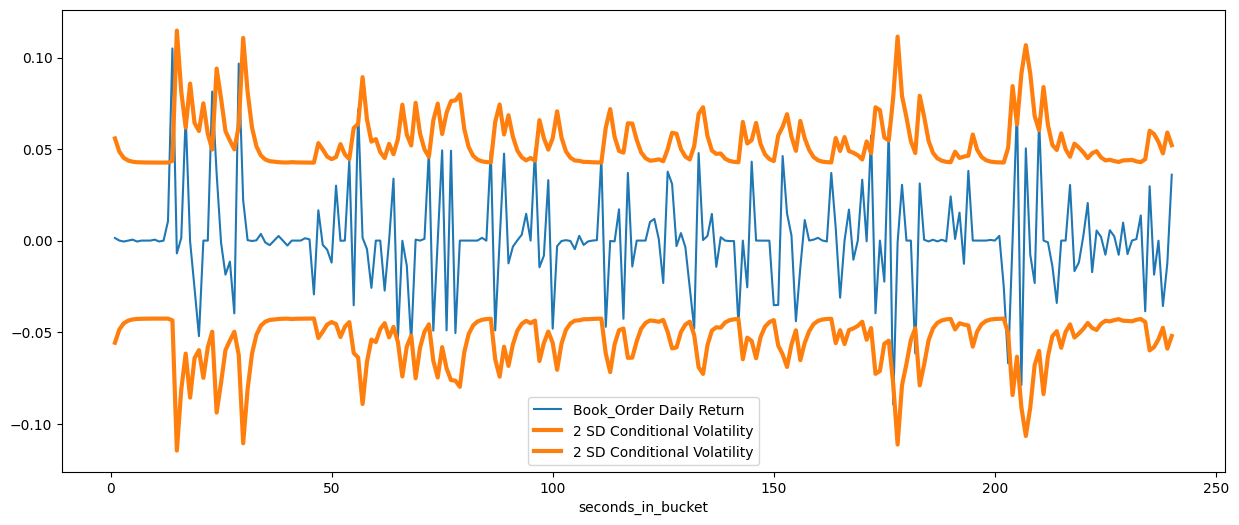

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `df_bo_train`
df_bo_train.plot(ax=ax, label="Book_Order Daily Return")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)

# Add axis labels
plt.xlabel("seconds_in_bucket")


# Add legend
plt.legend();

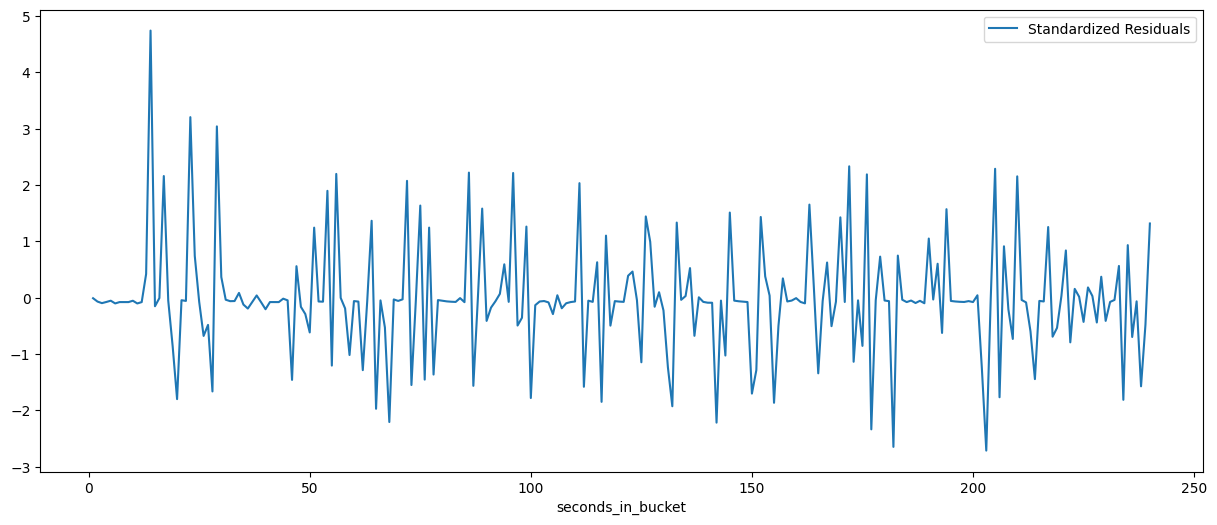

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("seconds_in_bucket")


# Add legend
plt.legend();

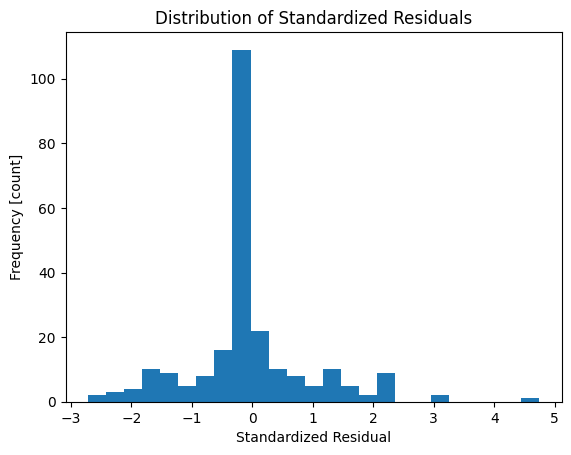

In [27]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals");

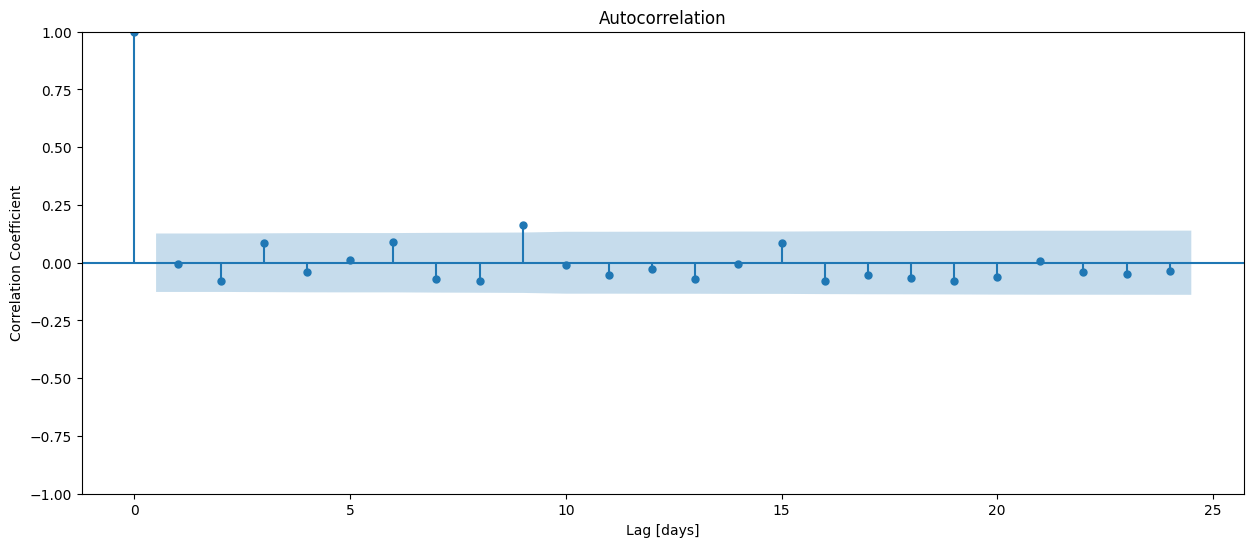

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [29]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
240,0.00086


# walk-forward validation model

In [30]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df_bo) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df_bo.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0]**0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df_bo.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (60,)


242    0.025170
243    0.025636
244    0.023298
245    0.028291
246    0.028585
dtype: float64

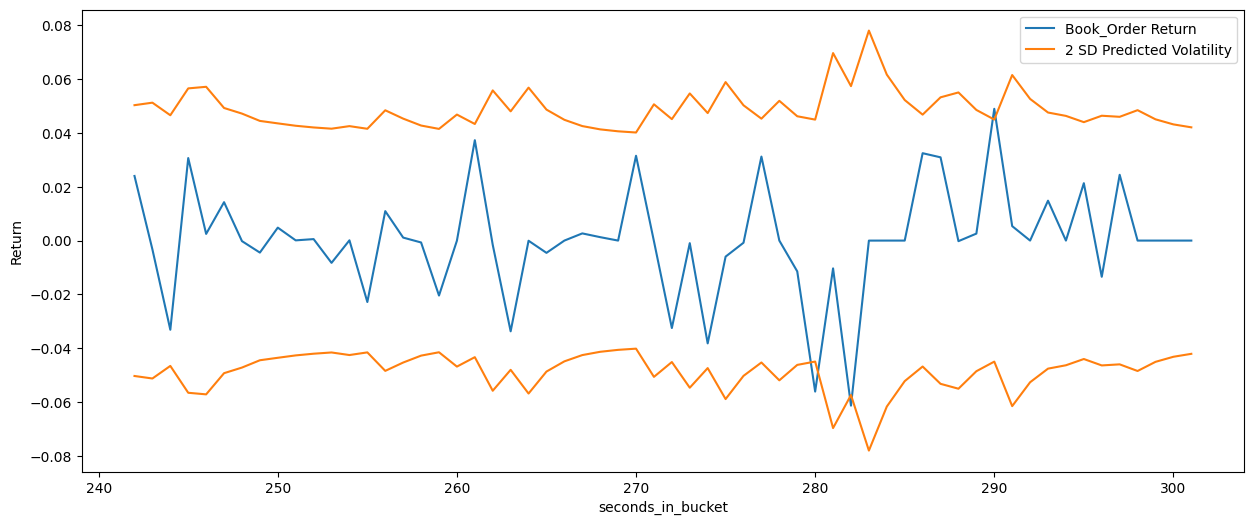

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
df_bo.tail(test_size).plot(ax=ax, label="Book_Order Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("seconds_in_bucket")
plt.ylabel("Return")

# Add legend
plt.legend()

# Communicate Results

In [32]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

          h.1       h.2       h.3       h.4       h.5
300  0.021051  0.022885  0.024098  0.024922  0.025489
